In [1]:
import torch
import torch.nn as nn

In [2]:
architecture_config = [
    # Tuples: (kernel_size, num_filters, stride, padding)
    # M: MaxPooling layer with 2x2 stride and kernel_size 2x2
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    # List: [Tuples, last  value tells no. of repeats]
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]

In [3]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)  # 0.1- slope

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))

In [4]:
class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [CNNBlock(in_channels, out_channels=x[1], kernel_size=x[0], stride=x[2], padding=x[3])]
                in_channels = x[1]

            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

            elif type(x) == list:
                conv1 = x[0]  # Tupple
                conv2 = x[1]  # tupple  
                num_repeats = x[2]   # Integer

                for _ in range(num_repeats):
                    layers += [CNNBlock(in_channels, conv1[1], kernel_size=conv1[0], stride=conv1[2],padding=conv1[3])]
                    layers += [CNNBlock(conv1[1], conv2[1], kernel_size=conv2[0], stride=conv2[2], padding=conv2[3])]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

    def _create_fcs(self, split_size, num_boxes, num_classes):
        S, B, C = split_size, num_boxes, num_classes

        # In original paper this should be
        # nn.Linear(1024*S*S, 4096),
        # nn.LeakyReLU(0.1),
        # nn.Linear(4096, S*S*(B*5+C))

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)))  # (S, S, 30)


def test(S=7, B=2, C=20):
  model = Yolov1(split_size=S, num_boxes=B, num_classes=C)
  x = torch.randn((2, 448, 448, 3))
  print(model(x).shape)

In [5]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/gdrive/My Drive/Kaggle'

In [7]:
!kaggle datasets download -d aladdinpersson/pascalvoc-yolo

100% 4.29G/4.31G [00:26<00:00, 167MB/s]
100% 4.31G/4.31G [00:26<00:00, 177MB/s]


In [8]:
!unzip \*.zip && rm *.zip

Streaming output truncated to the last 5000 lines.
  inflating: labels/2009_004289.txt  
  inflating: labels/2009_004290.txt  
  inflating: labels/2009_004291.txt  
  inflating: labels/2009_004295.txt  
  inflating: labels/2009_004298.txt  
  inflating: labels/2009_004300.txt  
  inflating: labels/2009_004301.txt  
  inflating: labels/2009_004303.txt  
  inflating: labels/2009_004307.txt  
  inflating: labels/2009_004308.txt  
  inflating: labels/2009_004309.txt  
  inflating: labels/2009_004312.txt  
  inflating: labels/2009_004315.txt  
  inflating: labels/2009_004316.txt  
  inflating: labels/2009_004317.txt  
  inflating: labels/2009_004319.txt  
  inflating: labels/2009_004322.txt  
  inflating: labels/2009_004323.txt  
  inflating: labels/2009_004324.txt  
  inflating: labels/2009_004327.txt  
  inflating: labels/2009_004328.txt  
  inflating: labels/2009_004329.txt  
  inflating: labels/2009_004332.txt  
  inflating: labels/2009_004334.txt  
  inflating: labels/2009_004336.txt  

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter

In [10]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates intersection over union

    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)
        box_format (str): midpoint/corners, if boxes (x,y,w,h) or (x1,y1,x2,y2)

    Returns:
        tensor: Intersection over union for all examples
    """

    if box_format == "midpoint":
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    if box_format == "corners":
        box1_x1 = boxes_preds[..., 0:1]
        box1_y1 = boxes_preds[..., 1:2]
        box1_x2 = boxes_preds[..., 2:3]
        box1_y2 = boxes_preds[..., 3:4]  # (N, 1)
        box2_x1 = boxes_labels[..., 0:1]
        box2_y1 = boxes_labels[..., 1:2]
        box2_x2 = boxes_labels[..., 2:3]
        box2_y2 = boxes_labels[..., 3:4]

    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # .clamp(0) is for the case when they do not intersect
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [11]:
def non_max_suppression(bboxes, iou_threshold, threshold, box_format="corners"):
    """
    Does Non Max Suppression given bboxes

    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x1, y1, x2, y2]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU)
        box_format (str): "midpoint" or "corners" used to specify bboxes

    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)

        bboxes = [
            box
            for box in bboxes
            if box[0] != chosen_box[0]
               or intersection_over_union(
                torch.tensor(chosen_box[2:]),
                torch.tensor(box[2:]),
                box_format=box_format,
            )
               < iou_threshold
        ]

        bboxes_after_nms.append(chosen_box)

    return bboxes_after_nms

In [12]:
def mean_average_precision(
        pred_boxes, true_boxes, iou_threshold=0.5, box_format="midpoint", num_classes=20
):
    """
    Calculates mean average precision

    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x1, y1, x2, y2]
        true_boxes (list): Similar as pred_boxes except all the correct ones
        iou_threshold (float): threshold where predicted bboxes is correct
        box_format (str): "midpoint" or "corners" used to specify bboxes
        num_classes (int): number of classes

    Returns:
        float: mAP value across all classes given a specific IoU threshold
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:]),
                    box_format=box_format,
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)


In [13]:
def plot_image(image, boxes):
    """Plots predicted bounding boxes on the image"""
    im = np.array(image)
    height, width, _ = im.shape

    # Create figure and axes
    fig, ax = plt.subplots(1)
    # Display the image
    ax.imshow(im)

    # box[0] is x midpoint, box[2] is width
    # box[1] is y midpoint, box[3] is height

    # Create a Rectangle potch
    for box in boxes:
        box = box[2:]
        assert len(box) == 4, "Got more values than in x, y, w, h, in a box!"
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
        rect = patches.Rectangle(
            (upper_left_x * width, upper_left_y * height),
            box[2] * width,
            box[3] * height,
            linewidth=1,
            edgecolor="r",
            facecolor="none",
        )
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

In [14]:
def get_bboxes(
        loader,
        model,
        iou_threshold,
        threshold,
        pred_format="cells",
        box_format="midpoint",
        device="cuda",
):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
                box_format=box_format,
            )

            # if batch_idx == 0 and idx == 0:
            #    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
            #    print(nms_boxes)

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes

In [15]:
def convert_cellboxes(predictions, S=7):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios. Tried to do this
    vectorized, but this resulted in quite difficult to read
    code... Use as a black box? Or implement a more intuitive,
    using 2 for loops iterating range(S) and convert them one
    by one, resulting in a slower but more readable implementation.
    """

    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, 30)
    bboxes1 = predictions[..., 21:25]
    bboxes2 = predictions[..., 26:30]
    scores = torch.cat(
        (predictions[..., 20].unsqueeze(0), predictions[..., 25].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :20].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., 20], predictions[..., 25]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds

In [16]:
def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

In [17]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

In [18]:
def load_checkpoint(checkpoint, model, optimizer):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])

Computing the Loss Function for Yolo v1:

In [19]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        self.S = S  # split size of image (SxS)
        self.B = B  # number of bounding boxes
        self.C = C  # number of classes

        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)  # (N, S*S(C+B*5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        # [..., 21:25] --- [N, S, S, 25]
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        iou_maxes, bestbox = torch.max(ious, dim=0)  # The box with highest IoU out of the two predictions will be indices of 0/1
        exists_box = target[..., 20].unsqueeze(3)  # identity function 1_obj_i (0/1)

        # 1. BOX LOSS:-
        # The first bbox(21:25) will return 0 if obj is present in it. The second bbox(26:30) will return 1 if obj is present in it.
        box_predictions = exists_box * ((bestbox * predictions[..., 26:30]) + ((1 - bestbox) * predictions[..., 21:25]))
        box_targets = exists_box * target[..., 21:25]

        # [N, S, S, 2:4] --- Bbox[x, y, w, h] -> w,h
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(torch.abs(box_predictions[..., 2:4] + 1e-6))
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(torch.flatten(box_predictions, end_dim=-2), torch.flatten(box_targets, end_dim=-2))

        # 2. OBJECT LOSS:-
        pred_box = (bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21])
        object_loss = self.mse(torch.flatten(exists_box * pred_box), torch.flatten(exists_box * target[..., 20:21]))

        # 3. NO OBJECT LOSS:-
        no_object_loss = self.mse(torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1), torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1))
        no_object_loss += self.mse(torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1), torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1))

        # 4. CLASS LOSS:-
        class_loss = self.mse(torch.flatten(exists_box * predictions[..., :20], end_dim=-2), torch.flatten(exists_box * target[..., :20], end_dim=-2))

        # Total loss
        loss = (self.lambda_coord * box_loss + object_loss + self.lambda_noobj * no_object_loss + class_loss)
        return loss

Processing the Dataset:

In [20]:
import os
import pandas as pd
from PIL import Image

In [21]:
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, img_dir, label_dir, S=7, B=2, C=20, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        boxes = []
        with open(label_path) as f:
            for label in f.readlines():
                class_label, x, y, width, height = [
                    float(x) if float(x) != int(float(x)) else int(x)
                    for x in label.replace("\n", "").split()]

                boxes.append([class_label, x, y, width, height])

        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        boxes = torch.tensor(boxes)

        if self.transform:
            image, boxes = self.transform(image, boxes)

        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            i, j = int(self.S * y), int(self.S * x)  # # i,j represents the cell row and cell column
            x_cell, y_cell = self.S * x - j, self.S * y - i  # Since x, y in dataset is relative to entire image, trying to make it relative to cell
            width_cell, height_cell = (width * self.S, height * self.S)  # making w,h relative to cell

            if label_matrix[i, j, 20] == 0:
                label_matrix[i, j, 20] = 1
                box_coordinates = torch.tensor([x_cell, y_cell, width_cell, height_cell])
                label_matrix[i, j, 21:25] = box_coordinates
                label_matrix[i, j, class_label] = 1

        return image, label_matrix

Training the model on the Dataset and Evaluation:

In [22]:
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader
!pip install fsspec

seed = 123
torch.manual_seed(seed)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 141 kB 28.7 MB/s 


In [23]:
# Hyperparameters
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 16
WEIGHT_DECAY = 5e-4
EPOCHS = 200
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = True
IMG_DIR = "/content/images"
LABEL_DIR = "/content/labels"


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor()])

In [24]:
def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")

In [25]:
def main():
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    loss_fn = YoloLoss()

    train_dataset = VOCDataset("/content/100examples.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR)
    test_dataset = VOCDataset("/content/test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR)

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True) 

    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True)
    

    for epoch in range(EPOCHS):

        pred_boxes, target_boxes = get_bboxes(train_loader, model, iou_threshold=0.5, threshold=0.45)
        mean_avg_prec = mean_average_precision(pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint")
        print(f"Epoch: {epoch}    Train mAP: {mean_avg_prec}")

        train_fn(train_loader, model, optimizer, loss_fn)

    for x, y in train_loader:
           x = x.to(DEVICE)
           for idx in range(8,14):
               bboxes = cellboxes_to_boxes(model(x))
               bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.45, box_format="midpoint")
               plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

Epoch: 0    Train mAP: 0.0


100%|██████████| 6/6 [00:04<00:00,  1.45it/s, loss=951]

Mean loss was 990.0919596354166


Epoch: 1    Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.49it/s, loss=383]

Mean loss was 506.7364196777344


Epoch: 2    Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.48it/s, loss=440]

Mean loss was 381.2568868001302


Epoch: 3    Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.47it/s, loss=355]

Mean loss was 307.8974151611328


Epoch: 4    Train mAP: 0.0


100%|██████████| 6/6 [00:02<00:00,  2.47it/s, loss=272]

Mean loss was 223.81946818033853


Epoch: 5    Train mAP: 0.0009472345118410885


100%|██████████| 6/6 [00:02<00:00,  2.49it/s, loss=108]

Mean loss was 179.30002975463867


Epoch: 6    Train mAP: 0.0009371250635012984


100%|██████████| 6/6 [00:02<00:00,  2.43it/s, loss=135]

Mean loss was 154.07793680826822


Epoch: 7    Train mAP: 0.00048440051614306867


100%|██████████| 6/6 [00:02<00:00,  2.42it/s, loss=113]

Mean loss was 124.5157699584961


Epoch: 8    Train mAP: 0.015612366609275341


100%|██████████| 6/6 [00:02<00:00,  2.45it/s, loss=148]

Mean loss was 123.39964167277019


Epoch: 9    Train mAP: 0.009974573738873005


100%|██████████| 6/6 [00:02<00:00,  2.45it/s, loss=101]

Mean loss was 114.43187586466472


Epoch: 10    Train mAP: 0.06366737931966782


100%|██████████| 6/6 [00:02<00:00,  2.47it/s, loss=83.3]

Mean loss was 100.99756368001302


Epoch: 11    Train mAP: 0.20300689339637756


100%|██████████| 6/6 [00:02<00:00,  2.43it/s, loss=115]

Mean loss was 93.5766830444336


Epoch: 12    Train mAP: 0.38257449865341187


100%|██████████| 6/6 [00:02<00:00,  2.43it/s, loss=88.4]

Mean loss was 87.60554885864258


Epoch: 13    Train mAP: 0.524573028087616


100%|██████████| 6/6 [00:02<00:00,  2.43it/s, loss=80]

Mean loss was 83.73108673095703


Epoch: 14    Train mAP: 0.5964064002037048


100%|██████████| 6/6 [00:02<00:00,  2.44it/s, loss=90.7]

Mean loss was 76.6698506673177


Epoch: 15    Train mAP: 0.6438610553741455


100%|██████████| 6/6 [00:02<00:00,  2.43it/s, loss=82.8]

Mean loss was 67.7746950785319


Epoch: 16    Train mAP: 0.6675940752029419


100%|██████████| 6/6 [00:02<00:00,  2.42it/s, loss=61.8]

Mean loss was 67.86097462972005


Epoch: 17    Train mAP: 0.7797085642814636


100%|██████████| 6/6 [00:03<00:00,  1.96it/s, loss=67.8]

Mean loss was 65.95153172810872


Epoch: 18    Train mAP: 0.7662004232406616


100%|██████████| 6/6 [00:02<00:00,  2.38it/s, loss=60.4]

Mean loss was 56.65227762858073


Epoch: 19    Train mAP: 0.8198563456535339


100%|██████████| 6/6 [00:02<00:00,  2.43it/s, loss=39.1]

Mean loss was 53.004645665486656


Epoch: 20    Train mAP: 0.8426865339279175


100%|██████████| 6/6 [00:02<00:00,  2.18it/s, loss=57.3]

Mean loss was 53.25400479634603


Epoch: 21    Train mAP: 0.8549005389213562


100%|██████████| 6/6 [00:02<00:00,  2.42it/s, loss=60.2]

Mean loss was 52.472880045572914


Epoch: 22    Train mAP: 0.8206340670585632


100%|██████████| 6/6 [00:02<00:00,  2.42it/s, loss=55.9]

Mean loss was 54.2745672861735


Epoch: 23    Train mAP: 0.8310920000076294


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=59.8]

Mean loss was 52.86443964640299


Epoch: 24    Train mAP: 0.8582314252853394


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=57.8]

Mean loss was 50.99333254496256


Epoch: 25    Train mAP: 0.8956777453422546


100%|██████████| 6/6 [00:02<00:00,  2.41it/s, loss=80.7]

Mean loss was 55.25221951802572


Epoch: 26    Train mAP: 0.7954118847846985


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=72.7]

Mean loss was 54.17200024922689


Epoch: 27    Train mAP: 0.7837121486663818


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=79.4]

Mean loss was 60.35130945841471


Epoch: 28    Train mAP: 0.8597580194473267


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=63.8]

Mean loss was 60.195618311564125


Epoch: 29    Train mAP: 0.8890650868415833


100%|██████████| 6/6 [00:02<00:00,  2.39it/s, loss=84.3]

Mean loss was 63.25639533996582


Epoch: 30    Train mAP: 0.8790799975395203


100%|██████████| 6/6 [00:02<00:00,  2.39it/s, loss=73.5]

Mean loss was 60.21243031819662


Epoch: 31    Train mAP: 0.8438078761100769


100%|██████████| 6/6 [00:02<00:00,  2.39it/s, loss=43.6]

Mean loss was 51.82122484842936


Epoch: 32    Train mAP: 0.8441575169563293


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=87.5]

Mean loss was 60.206136067708336


Epoch: 33    Train mAP: 0.906613826751709


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=66.2]

Mean loss was 54.906588872273765


Epoch: 34    Train mAP: 0.7617309093475342


100%|██████████| 6/6 [00:02<00:00,  2.39it/s, loss=49.6]

Mean loss was 62.19872220357259


Epoch: 35    Train mAP: 0.8903800249099731


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=46.3]

Mean loss was 51.139286041259766


Epoch: 36    Train mAP: 0.8884434700012207


100%|██████████| 6/6 [00:02<00:00,  2.38it/s, loss=29.3]

Mean loss was 49.59555276234945


Epoch: 37    Train mAP: 0.876483142375946


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=35.8]

Mean loss was 47.13871637980143


Epoch: 38    Train mAP: 0.8813034892082214


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=57.1]

Mean loss was 49.11963653564453


Epoch: 39    Train mAP: 0.8584325909614563


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=27.9]

Mean loss was 41.40309969584147


Epoch: 40    Train mAP: 0.9121345281600952


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=51.5]

Mean loss was 42.373940785725914


Epoch: 41    Train mAP: 0.9286977052688599


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=34.1]

Mean loss was 36.40313243865967


Epoch: 42    Train mAP: 0.9534982442855835


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=36.9]

Mean loss was 34.91881783803304


Epoch: 43    Train mAP: 0.9220114946365356


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=38.3]

Mean loss was 39.341190020243324


Epoch: 44    Train mAP: 0.9000568389892578


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=42.3]

Mean loss was 36.33135732014974


Epoch: 45    Train mAP: 0.9629771709442139


100%|██████████| 6/6 [00:02<00:00,  2.37it/s, loss=27.5]

Mean loss was 28.717740694681805


Epoch: 46    Train mAP: 0.8866370916366577


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=30.7]

Mean loss was 27.326185544331867


Epoch: 47    Train mAP: 0.9524011611938477


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=30.9]

Mean loss was 27.946447054545086


Epoch: 48    Train mAP: 0.9162917137145996


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=28.5]

Mean loss was 25.63501803080241


Epoch: 49    Train mAP: 0.9648035764694214


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=25.9]

Mean loss was 23.13369337717692


Epoch: 50    Train mAP: 0.9674258232116699


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=18.9]

Mean loss was 23.70220438639323


Epoch: 51    Train mAP: 0.9460651278495789


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=15.7]

Mean loss was 25.97769530614217


Epoch: 52    Train mAP: 0.9662827253341675


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=25.3]

Mean loss was 22.604761123657227


Epoch: 53    Train mAP: 0.9168391227722168


100%|██████████| 6/6 [00:02<00:00,  2.35it/s, loss=21.6]

Mean loss was 23.248063723246258


Epoch: 54    Train mAP: 0.9110954999923706


100%|██████████| 6/6 [00:02<00:00,  2.36it/s, loss=32.2]

Mean loss was 21.877750078837078


Epoch: 55    Train mAP: 0.9232832193374634


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=32.9]

Mean loss was 22.22484318415324


Epoch: 56    Train mAP: 0.9655068516731262


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=18.6]

Mean loss was 24.087265332539875


Epoch: 57    Train mAP: 0.9125533103942871


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=50.2]

Mean loss was 29.712217330932617


Epoch: 58    Train mAP: 0.930188000202179


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=18.4]

Mean loss was 25.544137318929035


Epoch: 59    Train mAP: 0.9081263542175293


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=17.9]

Mean loss was 22.161457697550457


Epoch: 60    Train mAP: 0.9370435476303101


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=28.4]

Mean loss was 22.66247495015462


Epoch: 61    Train mAP: 0.9447728991508484


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=23.3]

Mean loss was 22.042570114135742


Epoch: 62    Train mAP: 0.9056622385978699


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=26.5]

Mean loss was 22.23177655537923


Epoch: 63    Train mAP: 0.9506226778030396


100%|██████████| 6/6 [00:02<00:00,  2.34it/s, loss=26.8]

Mean loss was 22.297771453857422


Epoch: 64    Train mAP: 0.9133224487304688


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=33.6]

Mean loss was 22.857629776000977


Epoch: 65    Train mAP: 0.9680212736129761


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=25.8]

Mean loss was 21.718483606974285


Epoch: 66    Train mAP: 0.9684759974479675


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=19.4]

Mean loss was 19.814486026763916


Epoch: 67    Train mAP: 0.9492777585983276


100%|██████████| 6/6 [00:02<00:00,  2.04it/s, loss=16.8]

Mean loss was 19.01367934544881


Epoch: 68    Train mAP: 0.9350036382675171


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=17.2]

Mean loss was 18.7839937210083


Epoch: 69    Train mAP: 0.9316145181655884


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=9.53]

Mean loss was 15.123361905415853


Epoch: 70    Train mAP: 0.9917508363723755


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=15.7]

Mean loss was 15.241296450297037


Epoch: 71    Train mAP: 0.9727331399917603


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=17.9]

Mean loss was 17.51929759979248


Epoch: 72    Train mAP: 0.946280300617218


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=36.3]

Mean loss was 24.074657758076984


Epoch: 73    Train mAP: 0.9263337254524231


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=22.3]

Mean loss was 30.496546427408855


Epoch: 74    Train mAP: 0.9062262177467346


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=24.2]

Mean loss was 27.037798245747883


Epoch: 75    Train mAP: 0.8941885232925415


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=15.9]

Mean loss was 24.40825907389323


Epoch: 76    Train mAP: 0.8728128671646118


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=21.9]

Mean loss was 21.795169512430828


Epoch: 77    Train mAP: 0.8877657055854797


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=19.8]

Mean loss was 19.488982518513996


Epoch: 78    Train mAP: 0.9349368810653687


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=24.2]

Mean loss was 20.13151756922404


Epoch: 79    Train mAP: 0.8989661335945129


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=12.7]

Mean loss was 17.8760560353597


Epoch: 80    Train mAP: 0.8936222791671753


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=17.8]

Mean loss was 16.085666020711262


Epoch: 81    Train mAP: 0.970851719379425


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=23.9]

Mean loss was 18.731212457021076


Epoch: 82    Train mAP: 0.9756094217300415


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=24.4]

Mean loss was 16.090962568918865


Epoch: 83    Train mAP: 0.9345073699951172


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=12.2]

Mean loss was 16.625519116719563


Epoch: 84    Train mAP: 0.9360176920890808


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=19.6]

Mean loss was 16.89288632074992


Epoch: 85    Train mAP: 0.9690998196601868


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=15.2]

Mean loss was 14.670885880788168


Epoch: 86    Train mAP: 0.9567381143569946


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=18.8]

Mean loss was 15.791762669881185


Epoch: 87    Train mAP: 0.9895865321159363


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=13.8]

Mean loss was 13.755719979604086


Epoch: 88    Train mAP: 0.9866864085197449


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=17.8]

Mean loss was 16.785598595937092


Epoch: 89    Train mAP: 0.9779362678527832


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=17.7]

Mean loss was 21.15268913904826


Epoch: 90    Train mAP: 0.9634959101676941


100%|██████████| 6/6 [00:02<00:00,  2.07it/s, loss=25.5]

Mean loss was 19.190848509470623


Epoch: 91    Train mAP: 0.9389419555664062


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=22.5]

Mean loss was 18.715108553568523


Epoch: 92    Train mAP: 0.9092230796813965


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=25]

Mean loss was 32.16264279683431


Epoch: 93    Train mAP: 0.8331332206726074


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=41.2]

Mean loss was 44.935693422953285


Epoch: 94    Train mAP: 0.893079936504364


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=28.5]

Mean loss was 32.690768559773765


Epoch: 95    Train mAP: 0.8829593658447266


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=42.8]

Mean loss was 28.070024808247883


Epoch: 96    Train mAP: 0.8989547491073608


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=25.6]

Mean loss was 27.23155339558919


Epoch: 97    Train mAP: 0.9052308201789856


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=23.6]

Mean loss was 28.994892438252766


Epoch: 98    Train mAP: 0.7546509504318237


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=41.4]

Mean loss was 30.006107966105144


Epoch: 99    Train mAP: 0.5242621302604675


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=12.8]

Mean loss was 28.047426223754883


Epoch: 100    Train mAP: 0.8048667907714844


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=14.1]

Mean loss was 24.686067899068195


Epoch: 101    Train mAP: 0.9710289239883423


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=69.8]

Mean loss was 27.597032864888508


Epoch: 102    Train mAP: 0.951084315776825


100%|██████████| 6/6 [00:02<00:00,  2.33it/s, loss=32.1]

Mean loss was 22.018498102823894


Epoch: 103    Train mAP: 0.9624171257019043


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=15.8]

Mean loss was 22.608065605163574


Epoch: 104    Train mAP: 0.9690002202987671


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=18.7]

Mean loss was 18.319899717966717


Epoch: 105    Train mAP: 0.9830503463745117


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=20.1]

Mean loss was 16.661062717437744


Epoch: 106    Train mAP: 0.956693172454834


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=10.3]

Mean loss was 15.955556233723959


Epoch: 107    Train mAP: 0.9816230535507202


100%|██████████| 6/6 [00:02<00:00,  2.32it/s, loss=10.6]

Mean loss was 16.003658612569172


Epoch: 108    Train mAP: 0.987137496471405


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=11.9]

Mean loss was 13.672945022583008


Epoch: 109    Train mAP: 0.973192036151886


100%|██████████| 6/6 [00:02<00:00,  2.25it/s, loss=12]

Mean loss was 12.140985012054443


Epoch: 110    Train mAP: 0.9914061427116394


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=11.9]

Mean loss was 9.4037397702535


Epoch: 111    Train mAP: 0.9744254350662231


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=10.8]

Mean loss was 8.793694575627645


Epoch: 112    Train mAP: 0.9776896238327026


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=17]

Mean loss was 9.508185227711996


Epoch: 113    Train mAP: 0.9946172833442688


100%|██████████| 6/6 [00:02<00:00,  2.19it/s, loss=7.53]

Mean loss was 7.689340829849243


Epoch: 114    Train mAP: 0.9778741598129272


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=7.42]

Mean loss was 8.321704864501953


Epoch: 115    Train mAP: 0.9637892842292786


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=13.9]

Mean loss was 8.992953300476074


Epoch: 116    Train mAP: 0.9814119338989258


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=10.7]

Mean loss was 8.44649108250936


Epoch: 117    Train mAP: 0.9960761070251465


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=7.55]

Mean loss was 8.726229190826416


Epoch: 118    Train mAP: 0.9959080815315247


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=9.38]

Mean loss was 6.814849456151326


Epoch: 119    Train mAP: 0.9838247895240784


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=7.51]

Mean loss was 7.943767706553142


Epoch: 120    Train mAP: 0.9823883771896362


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=8.48]

Mean loss was 6.714366594950358


Epoch: 121    Train mAP: 0.9843651652336121


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=8.88]

Mean loss was 8.28816850980123


Epoch: 122    Train mAP: 0.9824120402336121


100%|██████████| 6/6 [00:02<00:00,  2.24it/s, loss=8.07]

Mean loss was 7.38662584622701


Epoch: 123    Train mAP: 0.9953977465629578


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=6.86]

Mean loss was 5.6782214641571045


Epoch: 124    Train mAP: 0.991937518119812


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=7.44]

Mean loss was 7.1692720254262285


Epoch: 125    Train mAP: 0.9943208694458008


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=5.43]

Mean loss was 6.458318630854289


Epoch: 126    Train mAP: 0.9901483654975891


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=7.37]

Mean loss was 6.191262722015381


Epoch: 127    Train mAP: 0.988144040107727


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=9.11]

Mean loss was 6.912481387456258


Epoch: 128    Train mAP: 0.9900810122489929


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=5.03]

Mean loss was 6.194585720698039


Epoch: 129    Train mAP: 0.9823480844497681


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=8.43]

Mean loss was 7.652812639872233


Epoch: 130    Train mAP: 0.9539612531661987


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=10.8]

Mean loss was 7.097559928894043


Epoch: 131    Train mAP: 0.9694202542304993


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=11.7]

Mean loss was 8.450259764989218


Epoch: 132    Train mAP: 0.9777906537055969


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=13.7]

Mean loss was 9.211076180140177


Epoch: 133    Train mAP: 0.9919599294662476


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=16.3]

Mean loss was 10.19565518697103


Epoch: 134    Train mAP: 0.9829885363578796


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=7.11]

Mean loss was 9.104773998260498


Epoch: 135    Train mAP: 0.9717730283737183


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=5.41]

Mean loss was 8.417340914408365


Epoch: 136    Train mAP: 0.9932999610900879


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=10.7]

Mean loss was 10.094614028930664


Epoch: 137    Train mAP: 0.9516490697860718


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=8.76]

Mean loss was 9.884768644968668


Epoch: 138    Train mAP: 0.9857273101806641


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=9.21]

Mean loss was 11.17231027285258


Epoch: 139    Train mAP: 0.9670427441596985


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=15.5]

Mean loss was 11.047434171040853


Epoch: 140    Train mAP: 0.9888852834701538


100%|██████████| 6/6 [00:02<00:00,  2.31it/s, loss=11.5]

Mean loss was 8.865394433339437


Epoch: 141    Train mAP: 0.9918025135993958


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=8.6]

Mean loss was 8.094434102376303


Epoch: 142    Train mAP: 0.957514762878418


100%|██████████| 6/6 [00:02<00:00,  2.30it/s, loss=10.1]

Mean loss was 7.8793708483378095


Epoch: 143    Train mAP: 0.98736572265625


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=17.7]

Mean loss was 11.964441537857056


Epoch: 144    Train mAP: 0.9770774841308594


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=12]

Mean loss was 11.624499241511026


Epoch: 145    Train mAP: 0.977471649646759


100%|██████████| 6/6 [00:02<00:00,  2.17it/s, loss=16.9]

Mean loss was 12.408684889475504


Epoch: 146    Train mAP: 0.966080367565155


100%|██████████| 6/6 [00:02<00:00,  2.29it/s, loss=8.93]

Mean loss was 10.041014750798544


Epoch: 147    Train mAP: 0.9740071296691895


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=23.3]

Mean loss was 11.422354062398275


Epoch: 148    Train mAP: 0.9640903472900391


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=6.33]

Mean loss was 10.156380971272787


Epoch: 149    Train mAP: 0.9486176371574402


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=9.42]

Mean loss was 9.749864339828491


Epoch: 150    Train mAP: 0.9873444437980652


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=12.5]

Mean loss was 9.019547382990519


Epoch: 151    Train mAP: 0.9967500567436218


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=8.03]

Mean loss was 9.069169839223227


Epoch: 152    Train mAP: 0.9889639616012573


100%|██████████| 6/6 [00:02<00:00,  2.24it/s, loss=8.42]

Mean loss was 7.514676491419475


Epoch: 153    Train mAP: 0.9815502166748047


100%|██████████| 6/6 [00:02<00:00,  2.23it/s, loss=8.39]

Mean loss was 7.187901894251506


Epoch: 154    Train mAP: 0.9618985056877136


100%|██████████| 6/6 [00:02<00:00,  2.22it/s, loss=7.23]

Mean loss was 7.434822082519531


Epoch: 155    Train mAP: 0.9776643514633179


100%|██████████| 6/6 [00:02<00:00,  2.24it/s, loss=5.92]

Mean loss was 6.8882975578308105


Epoch: 156    Train mAP: 0.9865732192993164


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=6.94]

Mean loss was 6.552917718887329


Epoch: 157    Train mAP: 0.9578191637992859


100%|██████████| 6/6 [00:02<00:00,  2.19it/s, loss=5.48]

Mean loss was 6.447519302368164


Epoch: 158    Train mAP: 0.9852782487869263


100%|██████████| 6/6 [00:02<00:00,  2.19it/s, loss=5.14]

Mean loss was 6.631986697514852


Epoch: 159    Train mAP: 0.9787197113037109


100%|██████████| 6/6 [00:02<00:00,  2.14it/s, loss=7.36]

Mean loss was 6.80676547686259


Epoch: 160    Train mAP: 0.9814296960830688


100%|██████████| 6/6 [00:02<00:00,  2.07it/s, loss=6]

Mean loss was 5.729185660680135


Epoch: 161    Train mAP: 0.9890265464782715


100%|██████████| 6/6 [00:02<00:00,  2.16it/s, loss=9.08]

Mean loss was 6.158608436584473


Epoch: 162    Train mAP: 0.9784380793571472


100%|██████████| 6/6 [00:02<00:00,  2.17it/s, loss=11.1]

Mean loss was 8.827712535858154


Epoch: 163    Train mAP: 0.9909989237785339


100%|██████████| 6/6 [00:02<00:00,  2.18it/s, loss=9.95]

Mean loss was 7.615962505340576


Epoch: 164    Train mAP: 0.9815885424613953


100%|██████████| 6/6 [00:02<00:00,  2.14it/s, loss=6.29]

Mean loss was 7.331011454264323


Epoch: 165    Train mAP: 0.9510443806648254


100%|██████████| 6/6 [00:02<00:00,  2.17it/s, loss=7.5]

Mean loss was 10.650229612986246


Epoch: 166    Train mAP: 0.9515545964241028


100%|██████████| 6/6 [00:02<00:00,  2.17it/s, loss=8.46]

Mean loss was 8.970029354095459


Epoch: 167    Train mAP: 0.9436722993850708


100%|██████████| 6/6 [00:02<00:00,  2.15it/s, loss=7.32]

Mean loss was 9.274556398391724


Epoch: 168    Train mAP: 0.9617894291877747


100%|██████████| 6/6 [00:02<00:00,  2.19it/s, loss=9.54]

Mean loss was 9.813026348749796


Epoch: 169    Train mAP: 0.9324049949645996


100%|██████████| 6/6 [00:02<00:00,  2.20it/s, loss=5.88]

Mean loss was 8.975372632344564


Epoch: 170    Train mAP: 0.9236933588981628


100%|██████████| 6/6 [00:02<00:00,  2.20it/s, loss=9.7]

Mean loss was 9.08693234125773


Epoch: 171    Train mAP: 0.9795533418655396


100%|██████████| 6/6 [00:02<00:00,  2.20it/s, loss=7.69]

Mean loss was 8.674946467081705


Epoch: 172    Train mAP: 0.9707275629043579


100%|██████████| 6/6 [00:02<00:00,  2.25it/s, loss=9.46]

Mean loss was 9.82407800356547


Epoch: 173    Train mAP: 0.9907490611076355


100%|██████████| 6/6 [00:02<00:00,  2.21it/s, loss=8.36]

Mean loss was 10.113746166229248


Epoch: 174    Train mAP: 0.9778602719306946


100%|██████████| 6/6 [00:02<00:00,  2.23it/s, loss=14.4]

Mean loss was 10.302145004272461


Epoch: 175    Train mAP: 0.9698820114135742


100%|██████████| 6/6 [00:02<00:00,  2.25it/s, loss=10.2]

Mean loss was 9.596391836802164


Epoch: 176    Train mAP: 0.9774966239929199


100%|██████████| 6/6 [00:02<00:00,  2.22it/s, loss=8.26]

Mean loss was 9.165301322937012


Epoch: 177    Train mAP: 0.9790260195732117


100%|██████████| 6/6 [00:02<00:00,  2.25it/s, loss=6.85]

Mean loss was 9.21449645360311


Epoch: 178    Train mAP: 0.975659966468811


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=6.06]

Mean loss was 8.947355031967163


Epoch: 179    Train mAP: 0.9826980829238892


100%|██████████| 6/6 [00:02<00:00,  2.13it/s, loss=6.98]

Mean loss was 8.013319174448648


Epoch: 180    Train mAP: 0.9734272956848145


100%|██████████| 6/6 [00:02<00:00,  2.13it/s, loss=9.06]

Mean loss was 9.12844697634379


Epoch: 181    Train mAP: 0.9746220707893372


100%|██████████| 6/6 [00:02<00:00,  2.12it/s, loss=8.6]

Mean loss was 7.423167864481608


Epoch: 182    Train mAP: 0.9808666110038757


100%|██████████| 6/6 [00:03<00:00,  1.99it/s, loss=8.18]

Mean loss was 7.4993681112925215


Epoch: 183    Train mAP: 0.9827276468276978


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=6.73]

Mean loss was 6.454900503158569


Epoch: 184    Train mAP: 0.9602404832839966


100%|██████████| 6/6 [00:02<00:00,  2.24it/s, loss=5.8]

Mean loss was 6.0694789091746015


Epoch: 185    Train mAP: 0.9445492029190063


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=5.83]

Mean loss was 6.110312859217326


Epoch: 186    Train mAP: 0.9918658137321472


100%|██████████| 6/6 [00:02<00:00,  2.23it/s, loss=4.61]

Mean loss was 6.946762482325236


Epoch: 187    Train mAP: 0.9875708818435669


100%|██████████| 6/6 [00:02<00:00,  2.25it/s, loss=5.05]

Mean loss was 6.706673860549927


Epoch: 188    Train mAP: 0.9807244539260864


100%|██████████| 6/6 [00:02<00:00,  2.25it/s, loss=7.24]

Mean loss was 6.809252977371216


Epoch: 189    Train mAP: 0.9878671765327454


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=5.21]

Mean loss was 6.170229593912761


Epoch: 190    Train mAP: 0.9837329983711243


100%|██████████| 6/6 [00:02<00:00,  2.25it/s, loss=7.95]

Mean loss was 7.0918746789296465


Epoch: 191    Train mAP: 0.9701367616653442


100%|██████████| 6/6 [00:02<00:00,  2.24it/s, loss=9.46]

Mean loss was 7.153505245844523


Epoch: 192    Train mAP: 0.9957554936408997


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=4.42]

Mean loss was 5.947599808375041


Epoch: 193    Train mAP: 0.9995092153549194


100%|██████████| 6/6 [00:02<00:00,  2.28it/s, loss=4.86]

Mean loss was 5.8019966284434


Epoch: 194    Train mAP: 0.9986190795898438


100%|██████████| 6/6 [00:02<00:00,  2.23it/s, loss=7.35]

Mean loss was 6.368210951487224


Epoch: 195    Train mAP: 0.9737544059753418


100%|██████████| 6/6 [00:02<00:00,  2.25it/s, loss=4.55]

Mean loss was 5.722288688023885


Epoch: 196    Train mAP: 0.9693679809570312


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=5.66]

Mean loss was 6.61695925394694


Epoch: 197    Train mAP: 0.9588930010795593


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=6.98]

Mean loss was 6.598784764607747


Epoch: 198    Train mAP: 0.9641216397285461


100%|██████████| 6/6 [00:02<00:00,  2.27it/s, loss=6.73]

Mean loss was 5.835833152135213


Epoch: 199    Train mAP: 0.9990093111991882


100%|██████████| 6/6 [00:02<00:00,  2.26it/s, loss=3.86]

Mean loss was 6.1333010991414385


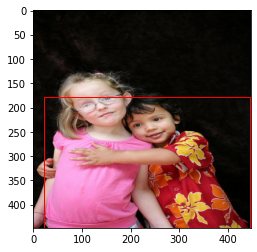

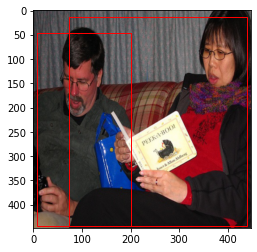

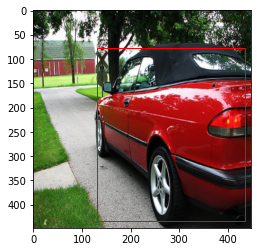

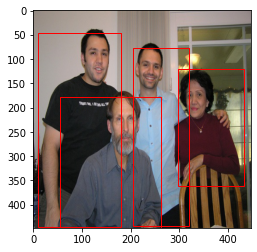

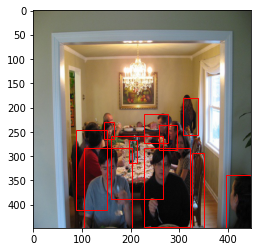

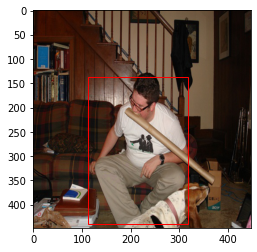

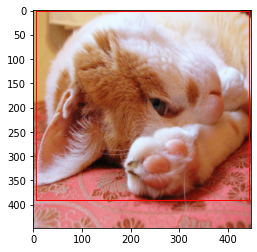

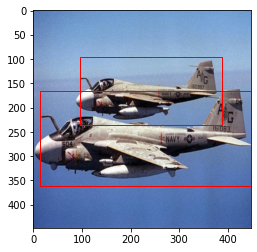

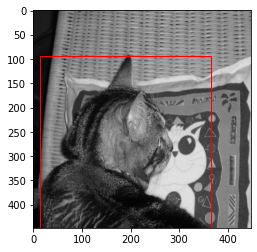

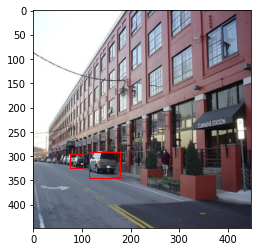

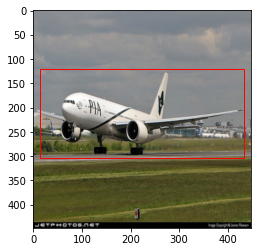

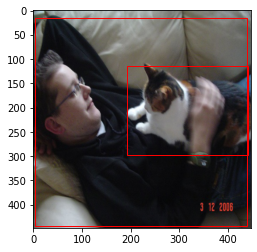

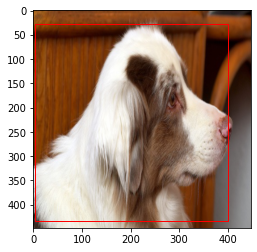

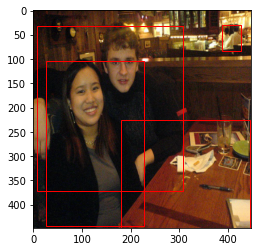

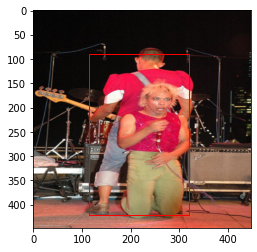

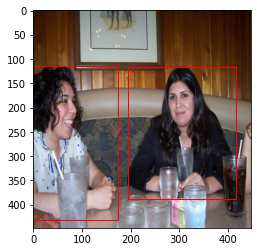

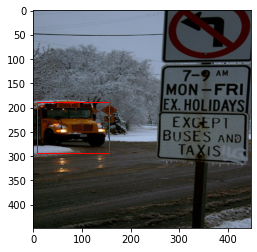

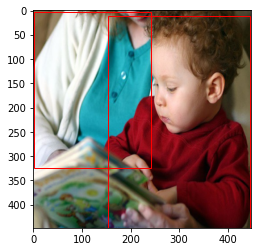

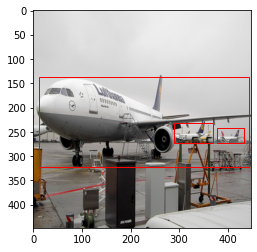

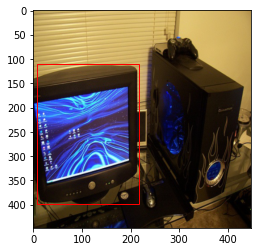

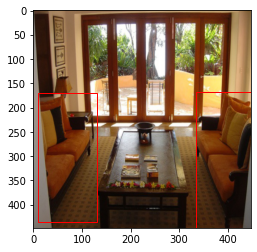

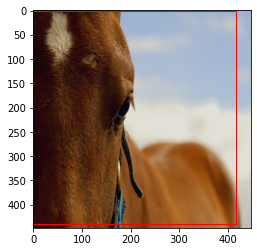

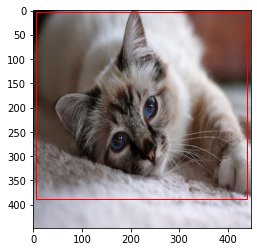

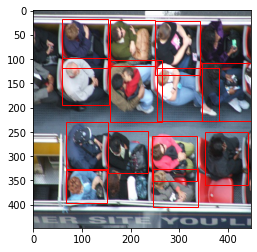

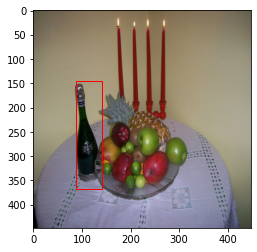

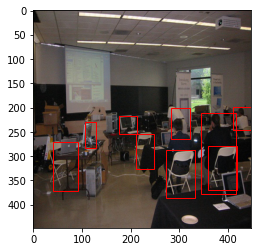

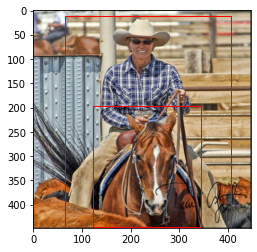

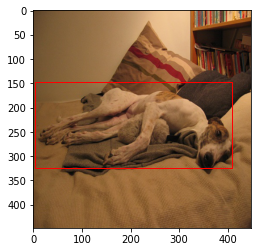

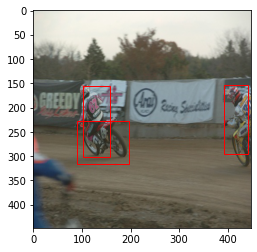

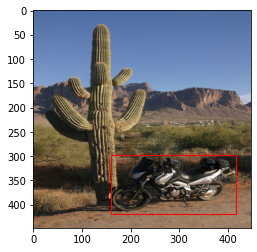

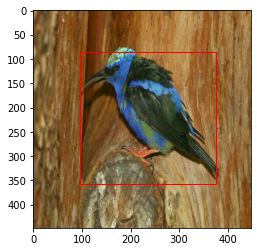

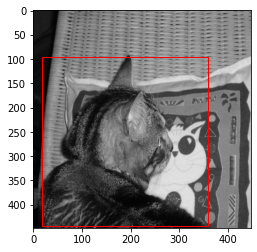

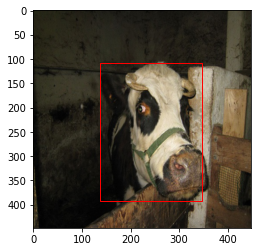

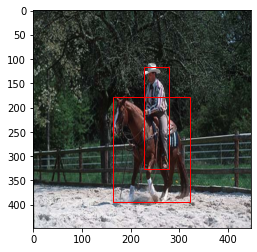

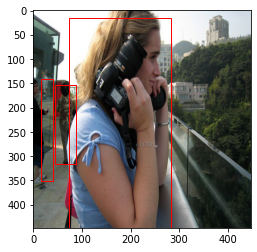

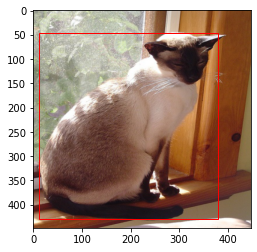

In [26]:
if __name__ == "__main__":
    main()